# CS 467 Data Mining Assignment
There are 3 main topics that I will be focusing on in this assignment:
* Has there been a trend in the <b>number of comments</b> that I have posted or received?
  - I was initially very active on FB as compared to what I am now in term of writing comments. I suspect a noticeable trend for this.
* How has the way I use <b>Parts of Speech</b> changed?
  - It has been a long time (6 years) since I joined FB. Language ought to change!
* What are the <b>Sentiments</b> behind my comments?
  - There have been numerous events in the past few years, both positive and negative, which led me to carry out this analysis. I wanted to see the change in sentiments through this.

In [47]:
import os
import json
from pprint import pprint
from textblob import TextBlob
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer

% matplotlib inline

### FB Comments Parsing from JSON

Load in All the JSON files from the path './fb_comments/'. Convert them to Python Parsable format. The JSON files needed some scrubbing as some entries were not in the right format that could be read by the Python JSON Parser. My Facebook Comments data was obtained from <a href="https://developers.facebook.com/docs/graph-api/overview">Facebook Graph API</a> and parsed using <a href="https://docs.python.org/2/library/json.html">JSON for Python</a>.

In [48]:
json_raw_data = []
folder_path = './fb_comments/'
for root, dirs, files in os.walk(folder_path):
    for count, file in enumerate(files):
            json_data = json.loads(open(folder_path + file).read())
            json_raw_data.append(json_data)

Cleanup the data structures and Formulate the comments_metadata list that contains the comments with the corresponding timestamps

In [49]:
comments_metadata = []

def process_dict(input_list):
    for i in range(len(input_list)):
        intm_dict = input_list[i]
        if (intm_dict.has_key('comments')):
            intm_list = intm_dict['comments']['data']
            for j in range(len(intm_list)):
                data_dict = intm_list[j]
                comments_metadata.append((data_dict['created_time'], data_dict['message']))

for i in range(8):
    curr_dict = json_raw_data[i]
    if (i == 0):
        curr_list = curr_dict['posts']['data'][1:]
    else:
        curr_list = curr_dict['data'][1:]
    process_dict(curr_list)

Strip the Time and Remove the ASCII characters to form well formatted strings

In [50]:
comments_metadata = [(str(curr_pair[0].split('T')[0]), str(curr_pair[1])) for curr_pair in comments_metadata]

Split comments by the year they were posted in.

In [51]:
comments_by_year = defaultdict(list)

for comment_data in comments_metadata:
    year = comment_data[0].split('-')[0]
    comments_by_year[year].append(comment_data[1])

### Making Sense of this Data

##### How have the number of comments that I receive and post changed over the years?

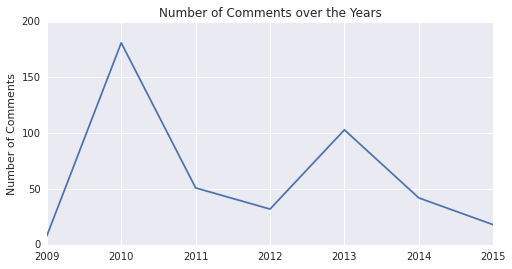

In [52]:
x = map(int, sorted(comments_by_year.keys()))
y = [len(comments_by_year[str(year)]) for year in x]

plt.figure(figsize=(8,4))
plt.plot(x, y)
plt.xticks(x, x)
plt.ylabel('Number of Comments')
plt.title('Number of Comments over the Years')
plt.show()

This is what I was expecting. There are 2 noticeable peaks in 2010 and in 2013. In 2010, I was taking my first major high school examinations. In 2013, I graduated from high school and started college at UIUC. These events account for the high number of comments during that time as most of the conversations involved talking about how exams went, how college started for my peers, and wanting to stay in touch with school friends. The decline in the number of comments from 2013 onwards was probably due to the workload in college and time difference between USA and India. There is also a steep increase in comments from 2009-2010 as I was new to FB at that time and was, probably as everyone else, on a commenting/posting spree :)

##### How has the way I use nouns, pronouns, verbs, adverbs, and adjectives changed over time?

Using <a href="https://textblob.readthedocs.org/en/dev/">textblob</a>, I performed POS-tagging. Split the tags according to the different years in which the comments were posted in. This might take a while to run depending on the size of the comments list.

In [53]:
pos_by_year = defaultdict(dict)

def process_pos_tags(yearly_set_of_tags):
    yearly_dict = defaultdict(int)
    for curr_tag_list in yearly_set_of_tags:
        for curr_tag_data in curr_tag_list:
            curr_tag = str(curr_tag_data[1])
            if ('JJ' in curr_tag):
                yearly_dict['adjectives'] += 1
            elif ('NN' in curr_tag and 'NNP' not in curr_tag):
                yearly_dict['common_nouns'] += 1
            elif ('NNP' in curr_tag):
                yearly_dict['proper_nouns'] += 1
            elif ('RB' in curr_tag):
                yearly_dict['adverbs'] += 1
            elif ('VB' in curr_tag):
                yearly_dict['verbs'] += 1
    return yearly_dict

for year in comments_by_year.keys():
    yearly_comments = comments_by_year[year]
    yearly_dict = defaultdict(int)
    yearly_set_of_tags = []
    for curr_comment in yearly_comments:
        blob = TextBlob(curr_comment)
        curr_pos_tags = blob.pos_tags
        yearly_set_of_tags.append(curr_pos_tags)
    yearly_dict = process_pos_tags(yearly_set_of_tags)
    pos_by_year[year] = yearly_dict

Get the various parts-of-speech tags from all the past years and create a visualization of how their percentages have changed.

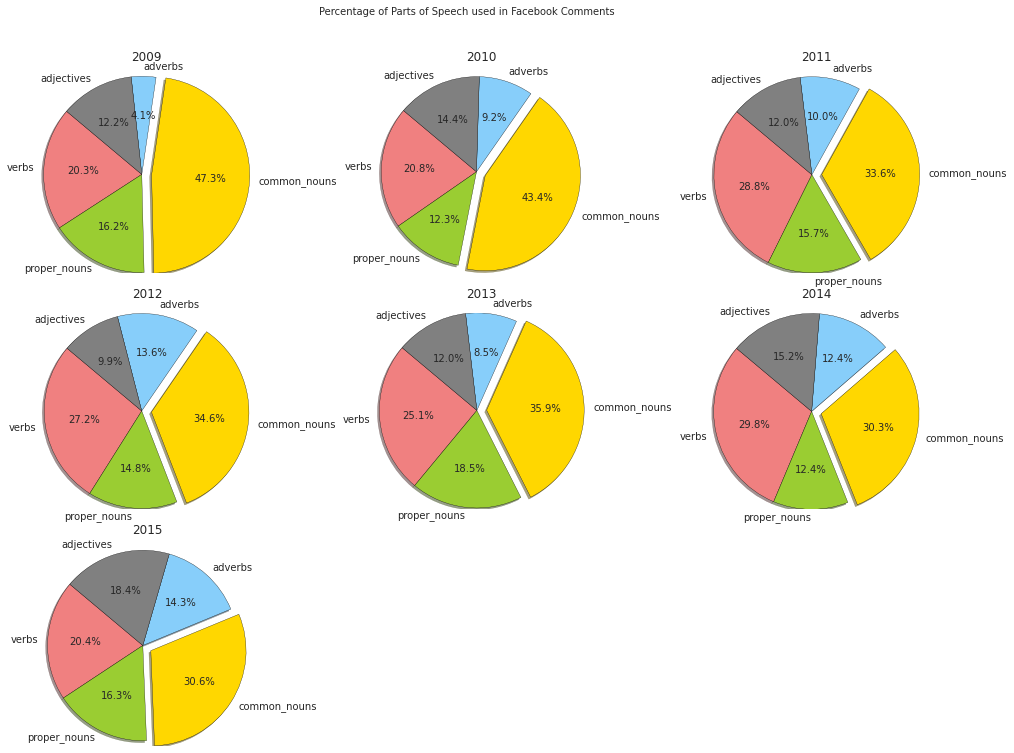

In [54]:
i = 0
fig, ax = plt.subplots(3, figsize=(17, 12))
for year in sorted(pos_by_year.keys()):
    i += 1
    x = [(key, pos_by_year[year][key]) for key in pos_by_year[year]]
    x = sorted(x, key=lambda x: x[0], reverse=True)

    labels = [curr_item[0] for curr_item in x]
    sizes = [curr_item[1] for curr_item in x]
    colors = ['lightcoral', 'yellowgreen', 'gold', 'lightskyblue', 'gray']
    explode = (0, 0, 0.1, 0, 0)  # explode 1st slice
    plt.subplot(3, 3, i)
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=140)
    plt.title(year, y=1.05)
    

    plt.axis('equal')
plt.suptitle('Percentage of Parts of Speech used in Facebook Comments')
plt.show()

I noticed that even though the percentage of adjectives, verbs, and proper nouns remained the same, there is a decline in the percentage of common nouns in my comments. There is also an increase in the percentage of adverbs.<br><br>
Visualization Detail: I chose to slice out a pie from the pie chart to show that that pie is the one that shares the majority of the share. It is easier to look at visually and the eyes do not linearly have to look through to find the maximum.

##### Has there been any change in the sentiments behind the comments over time?

Perform sentiment analysis on the comments using <a href="http://www.nltk.org/api/nltk.sentiment.html">NLTK</a>. Convert the polarity scores to a <a href="http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html">Pandas Dataframe</a> which segregates the scores by the year in which the comments were posted. Finally, use <a href="https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.violinplot.html">Seaborn Violinplot</a> to visualize the data.<br><br>
Classification Scheme:<br>
    - positive sentiment: 1
    - neutral sentiment: 0
    - negative sentiment: -1

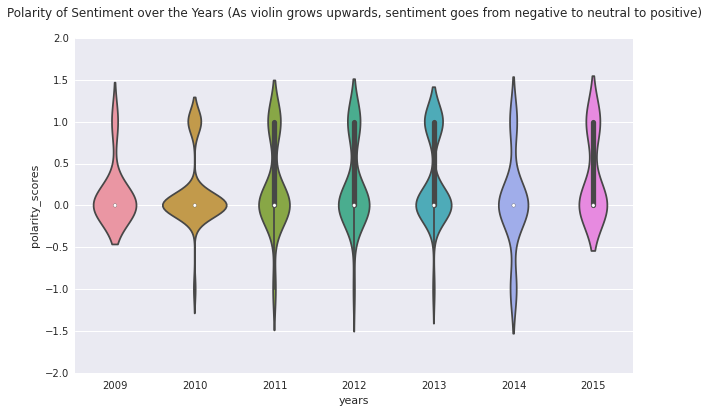

In [55]:
sid = SentimentIntensityAnalyzer()

polarity_df = pd.DataFrame()
polarity_scores = []
all_years = []

for year in comments_by_year.keys():
    list_comments = comments_by_year[year]
    for comment in list_comments:
        polarity_score = sid.polarity_scores(comment)
        pos_score = polarity_score['pos']
        neg_score = polarity_score['neg']
        neu_score = polarity_score['neu']
        scores = [('pos', pos_score), ('neg', neg_score), ('neu', neu_score)]
        max_score_label = max(scores, key=lambda item:item[1])[0]
        if (max_score_label == 'pos'):   
            polarity_scores.append(1)
        elif (max_score_label == 'neg'):   
            polarity_scores.append(-1)
        else:   
            polarity_scores.append(0)
        all_years.append(year)
polarity_df['polarity_scores'] = polarity_scores
polarity_df['years'] = all_years

ax = plt.figure(figsize=(10,6))
ax = sns.violinplot(x="years", y="polarity_scores", data=polarity_df)
plt.title('Polarity of Sentiment over the Years (As violin grows upwards, sentiment goes from negative to neutral to positive)', y=1.05)

I noticed that through the years, in each year, there are mostly neutral comments followed by positive comments. I observed the width of the positive comments increasing in the years 2010-2011 and 2013. This is probably because the Indian Cricket Team won the Cricket World Cup in 2010-2011 and I started college in 2013 along with many of my peers. Also in 2015, I joined Twitter and tweeted to some celebrities who to my surprise, replied to my tweets! I posted those on FB and got plenty of comments back, which is why I see a blob in the positive section for 2015.<br><br>Other important blobs are the negative ones in 2011 and 2014. Although the one in 2011 is not thick, it is present as I remember commenting about Steve Jobs' death. I also got comments back for those comments which ascribe to the negative sentiment behind them. In 2014, the Indian Cricket Team lost an important World Cup which is probably why there is a blob of negative comments.

### Conclusion

Before deep diving into the details, I would first like to start off by defining what an active FB user is. According to me, it is a person who logs in frequently into FB and might or might not post or comment on others posts. Scrolling through the news feed, seeing videos and pictures is under the category of activeness of FB. I am an acive user in the sense that I do not post or comment that frequently. This is probably why after the initial FB hype, my comments have declined over the past few years.<br><br>
It is very interesting to notice that my common noun percentage is on the decline whereas my adverbs usage is increasing. This might be because I have started to write shorter comments as compared to what I used to write initially. The result of this would definitely point to less common nouns usage and higher reliability on words which convey my message quicker i.e. adverbs. An example of this would be writing 'definitely' instead of 'I am sure about that'.
<br><br>
Most of my comments are either positive or neutral with very few of them being negative. Some of the classifications might be an error on part of the NLTK Sentiment Analysis Library but for the most part, I agree with the trends that I saw. As a user, I do not generally tend to write negative comments and a reason for that is maybe because I do not comment that often on posts. I only comment when I see something extremely interesting and most of them are in fact neutral.<br><br>
Facebook data provides a means of introspection, a way to humor oneself, notice interesting self patterns! I enjoyed doing this assignment and look forward to more!